# Notebook 2: Option Trading with ML
## Feature Selection
What could possibly go wrong?

5/10/2020

## Purpose of this Notebook - Select the Best Features from the Feature Set
In the first notebook in this series we created a set of features from stock price information and earnings report date. Do these features actually contain enough information for a Learner to predict profitable stock option trades? In this notebook we will evaluate the features using four techniques to determine the quality of each feature. Finally, you will choose the best features to use in training the Learners.

Good features can help a Learner perform well. Conversely, bad features can cause many problems for a Learner, such as over-fitting and long train and test times. Leakage of future information into a feature set can cause completely erroneous results and failure of the entire project.

## Contents
As discussed above, feature reduction and elimination are powerful tools to improve Learner performance. Many techniques are available, so consider these four as just a sample to get you started.

0. Scaling - Scaling is not really a feature reduction tool. Consider it more of a feature improvement tool. Learners prefer to work with features that have similar scale and distribution. This simplifies the mathematical analysis and reduces scaling errors. StandardScaler converts every feature to a common normal distribution - usually N(0,1). Feature scaling has many complexities, so read the docs to understand how it can affect your features, especially features with non-normal distributions.

1. SelectKBest - univariate feature selection and ranking. SelectKBest scores each feature individually, then ranks the features according to the scores.

2. Correlation with Heat Map - Using the pandas corr function and the Seaborn library, we can map the cross-correlations of each feature with every other feature and, most important, with the label.

3. RFE - Recursive Feature Elimination. RFE is a powerful function in the SKLearn library. It recursively tests groups of features together, gradually eliminating the weakest ones, until it arrives at the smallest ensemble of features that produces the best results. Read the docs to learn more about RFE.

4. Principal Component Analysis (PCA) - PCA is not really a feature reduction tool. It performs dimension reduction, by combining features into a few, typically two or three, artificial features by combining the original features mathematically to preserve the maximum independent variance. For problems with many dimensions, say hundreds or more, PCA can be very effective.


- What You Need: Basic knowledge of Python, pandas, numpy, dataframes, and statistics.

- What You Don't Need: Knowledge of linear algebra, calculus, or Machine Learning. The Python libraries, particularly scipy and SKLearn for ML, do all the heavy lifting.

You Will Learn:

- How to scale a feature set with StandardScaler.
- Three feature selection methods.
- Principal Component Analysis (PCA)
- a few more capabilities of MatPlotlib


## StandardScaler and SelectKBest

Evaluation Questions
- What is the importance of feature scaling?
- Before you look at the results, choose the three features that you rank highest.
- How do your choices compare with the ranking of SelectKBest? Any surprises? Why?
- Given the scores from SelectKBest, how many features woyuld you choose for the training set? Why?

Code Questions
- What is the distribution of the features after running StandardScaler? Print a few to confirm?
- What happens to the mean and standard deviation values of each original feature? Print a few.
- How does SelectKBest calculate the feature score?
- Create a dataframe to collect the scores and ranking for each feature selection algorithm. 
- Use this dataframe to compare the results at the end of this notebook.
- The features ER - Expiry and 2 day Velocity show NaNs as scores. Why? Can you change these scores?

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.preprocessing     import StandardScaler
from sklearn.decomposition     import PCA


raw_features = pd.read_csv('opt_sample.csv', index_col = 0)

# Remove duplicate features

dup_features = ['STO_open_strike_delta%', 'stock_price_at_open']


print(raw_features.shape)
#print(raw_features['label'])
#features_np = raw_features.copy()
features_np = raw_features.to_numpy(copy = True)
#print('features_np')
#print(features_np)
#print(type(features_np))
scaler = StandardScaler()
features = scaler.fit_transform(features_np)
#print(features)
#print(features.head())
#print(features.columns.tolist())

X_train = features[:,:26]  #independent features (columns)
#print('X_train')
#print(X_train.head(5))
y_train = features[:,-1]    #label column
#print('y_train')
#print(y_train.head())

#apply SelectKBest class to measure and rank features.

bestfeatures = SelectKBest(score_func=f_classif, k='all')
fit = bestfeatures.fit(X_train,y_train)
feature_scores = pd.DataFrame(fit.scores_)
feature_columns = pd.DataFrame(raw_features.columns)
#print('feature_columns')
#print(feature_columns)

#print(feature_scores.head(5), feature_columns.head(5))

feature_scores = pd.concat([feature_scores, feature_columns],axis=1)
#print(feature_scores.head(8))
feature_scores.columns = ['Score', 'Feature']
#print(feature_scores.head(5))
feature_scores.sort_values(['Score'], ascending = False, inplace = True)
feature_scores = feature_scores.reset_index(drop = True)
feature_scores['Score'] = round(feature_scores['Score']) 
print(feature_scores)


(8000, 29)
     Score                   Feature
0   1955.0   STO_offer_strike_delta%
1   1843.0                STO_strike
2   1475.0              STO_ask_fee%
3   1435.0             STO_offer_ARR
4   1109.0                30 day SMA
5   1029.0                45 day SMA
6    708.0                15 day SMA
7    618.0                10 day SMA
8    601.0                4 days old
9    594.0                3 days old
10   566.0                5 days old
11   540.0                2 days old
12   508.0       stock_price_at_open
13   505.0                1 days old
14   483.0  stock_price_at_STO_offer
15   354.0                45 day vel
16   207.0                Yearly Min
17    91.0                      MACD
18    65.0                       MFI
19    60.0                Yearly Max
20    29.0             STO_days_long
21     9.0                 5 day vel
22     4.0                30 day vel
23     1.0                15 day vel
24     1.0                       RSI
25     0.0                1

## Cross-correlation and Seaborn Heat Map
Evaluation questions
- What row shows the cross-correlation of each feature to the labell?
- Why is the correlation value exactly '1' for every cell on the diagonal?
- What is the difference between +1 and -1 in correlation? Which has more information? Why? Why not?

Code Questions
- Run the correlation heat map with the unscaled features. What differences, and why?
- Record the feature rankings in a column in your feature rank dataframe. Be sure to label it 'Cross-correlation.'


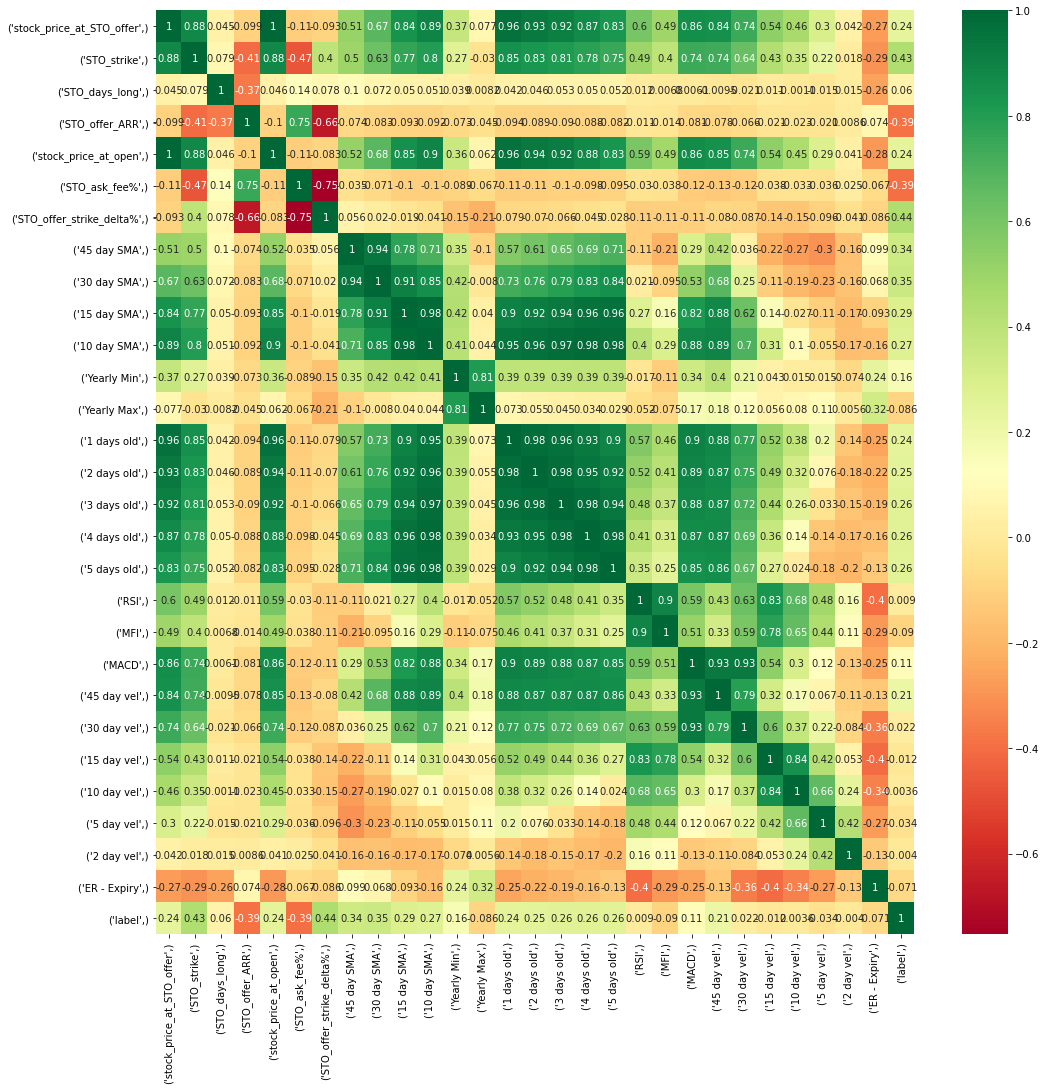

In [2]:
# Seaborn heat map
import seaborn as sb
import matplotlib.pyplot as plt

scaled_features = pd.DataFrame(features, columns = feature_columns)
corr_matrix = scaled_features.corr(method = 'pearson')
best_features = corr_matrix.index
plt.figure(figsize=(17,17))
#plot heat map
g=sb.heatmap(scaled_features[best_features].corr(),annot=True,cmap="RdYlGn")


## RFE
The Recursive Feature Eliminator (RFE) compares many sets of features to find the smallest set with the best results. Read the docs, then consider these questions.

Evaluation Questions
- How does RFE work?
- What is the estimator. What does it do?

Code Questions
- Describe the arguments given to the RFE selector.
- Time the execution of RFE selector. Why does it take so long to run?
- Would this execution time typically be a problem in a real-world application? Why, or not?
- Write a function to run RFE with a range of values. Any differences in the results? Why?
- Record the results of RFE ranking for the features in your feature ranking dataframe.

In [3]:
# Recursive Feature Elimination
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
estimator = SVR(kernel="linear")
selector = RFE(estimator, 5, step=1)
print('starting selector.')
selector = selector.fit(X_train, y_train)
print('finished selector.')
print(selector.support_)   # selected features
print(selector.ranking_) # feature rank


starting selector.
finished selector.
[False  True False False False False False False  True False  True False
 False False False False False False False False  True  True False False
 False False]
[ 2  1 20  8 11 22  3  7  1  4  1 14 19 21 10 18 13  9 12  6  1  1 15  5
 16 17]


## PCA
Evalution Questions
- How is PCA different from feature ranking?
- Describe explained variance (ev), and explained variance ratio (evr).
- Woud you consider the ev and evr shown to be adequate? Why, or not?

Code Questions
- Run PCA with different arguments. What arguments produce better results?
- Run PCA with non-scaled features. Any differences?

In [4]:
from sklearn.decomposition     import PCA

X_reduced = PCA(n_components = 2).fit(scaled_features)
print(X_reduced.components_)
print(X_reduced.explained_variance_)
print(X_reduced.explained_variance_ratio_)


[[ 0.26133058  0.23769884  0.0156068  -0.0386741   0.26207401 -0.0435118
  -0.00666361  0.15623461  0.20237079  0.25125063  0.26367906  0.1092549
   0.02208033  0.26883466  0.26749205  0.26560908  0.26082711  0.25274885
   0.15346961  0.12305551  0.25117004  0.24632578  0.21366457  0.1348632
   0.08809491  0.03202886 -0.02684347 -0.06711009  0.07622372]
 [-0.0617826  -0.01060758  0.01403264 -0.05254571 -0.05868341 -0.04925647
   0.0959132   0.31426661  0.27841115  0.16532753  0.1008584   0.13115386
   0.01657856 -0.018731    0.0154103   0.04908191  0.09312961  0.13011876
  -0.33469808 -0.34615616 -0.06376064  0.0321746  -0.15880441 -0.35501263
  -0.37658323 -0.32508908 -0.15816176  0.20391908  0.12604522]]
[13.49063383  4.50346778]
[0.46513612 0.15527258]


## Choose Your Features
Now you have all the information you need to select the features you will use to train the Learners. Compare the rankings of each feature selector by graphing the scores with MatplotLib. Write a function to do grouped bar charts, starting with the function in the next notebook that displays grouped bar charts. How can you display the information in the most effective way to showcase your selection?

I am eager to hear of your adventures in learning ML and especially in your challenges and results in tackling your own applications for ML. Please email me with questions, comments, and results of your work. 

I love to hear stories, so give me a shout.

Best wishes for selecting powerful features!

Richard Barrett
richard at rbshomes dot com



